# Setup the Env

In [52]:
import sys
import os

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

/home/sagemaker-user/capstone-2024-summer/src/rachel


# Import Libraries

In [53]:
# standard libraries
import pickle
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
!pip install seaborn -q
import seaborn as sns

# model
import tensorflow as tf

# cosine
from scipy.spatial.distance import pdist, squareform

# Load Dataset

In [54]:
with open('/home/sagemaker-user/capstone-2024-summer/data/crsp_rachel_dict.pkl', 'rb') as file:
  merged_dict = pickle.load(file)

In [55]:
train_numerical_x = merged_dict['train_dict']['numerical_x']
train_categorical_x = merged_dict['train_dict']['categorical_x']
train_y = merged_dict['train_dict']['y']

print("---- training data ----")
print("--> num_numerical_features:", len(train_numerical_x.keys()))
for key in train_numerical_x.keys():
  print(key, train_numerical_x[key].shape)
print("--> num_categorical_features:", len(train_categorical_x.keys()))
for key in train_categorical_x.keys():
  print(key, train_categorical_x[key].shape)
print("--> target_shape:", train_y['y'].shape)

---- training data ----
--> num_numerical_features: 19
return_scaled (219323, 128, 1)
shares_outstanding_scaled (219323, 128, 1)
num_trades_scaled (219323, 128, 1)
volume_scaled (219323, 128, 1)
close_price_scaled (219323, 128, 1)
market_cap_scaled (219323, 128, 1)
volatility_7_scaled (219323, 128, 1)
sector_weighted_avg_return_scaled (219323, 128, 1)
sector_simple_avg_return_scaled (219323, 128, 1)
day_of_week_x (219323, 128, 1)
day_of_week_y (219323, 128, 1)
day_of_month_x (219323, 128, 1)
day_of_month_y (219323, 128, 1)
day_of_year_x (219323, 128, 1)
day_of_year_y (219323, 128, 1)
month_of_year_x (219323, 128, 1)
month_of_year_y (219323, 128, 1)
week_of_year_x (219323, 128, 1)
week_of_year_y (219323, 128, 1)
--> num_categorical_features: 4
permno_id (219323, 1)
company_name (219323, 1)
primary_exchange (219323, 1)
naics_sector (219323, 1)
--> target_shape: (219323, 1)


In [56]:
val_numerical_x = merged_dict['val_dict']['numerical_x']
val_categorical_x = merged_dict['val_dict']['categorical_x']
val_y = merged_dict['val_dict']['y']

print("---- validation data ----")
print("--> num_numerical_features:", len(val_numerical_x.keys()))
for key in val_numerical_x.keys():
  print(key, val_numerical_x[key].shape)
print("--> num_categorical_features:", len(val_categorical_x.keys()))
for key in val_categorical_x.keys():
  print(key, val_categorical_x[key].shape)
print("--> target_shape:", val_y['y'].shape)

---- validation data ----
--> num_numerical_features: 19
return_scaled (49498, 128, 1)
shares_outstanding_scaled (49498, 128, 1)
num_trades_scaled (49498, 128, 1)
volume_scaled (49498, 128, 1)
close_price_scaled (49498, 128, 1)
market_cap_scaled (49498, 128, 1)
volatility_7_scaled (49498, 128, 1)
sector_weighted_avg_return_scaled (49498, 128, 1)
sector_simple_avg_return_scaled (49498, 128, 1)
day_of_week_x (49498, 128, 1)
day_of_week_y (49498, 128, 1)
day_of_month_x (49498, 128, 1)
day_of_month_y (49498, 128, 1)
day_of_year_x (49498, 128, 1)
day_of_year_y (49498, 128, 1)
month_of_year_x (49498, 128, 1)
month_of_year_y (49498, 128, 1)
week_of_year_x (49498, 128, 1)
week_of_year_y (49498, 128, 1)
--> num_categorical_features: 4
permno_id (49498, 1)
company_name (49498, 1)
primary_exchange (49498, 1)
naics_sector (49498, 1)
--> target_shape: (49498, 1)


# Prepare the data for modeling

### Train

In [57]:
training_features = np.concatenate(list(train_numerical_x.values()), axis=-1)
training_features.shape

(219323, 128, 19)

In [58]:
training_permno = train_categorical_x['permno_id']
training_cnam = train_categorical_x['company_name']
training_pxch = train_categorical_x['primary_exchange']
training_sctr = train_categorical_x['naics_sector']

training_permno.shape

(219323, 1)

In [59]:
training_y = train_y['y']

training_y.shape

(219323, 1)

### Val

In [60]:
validation_features = np.concatenate(list(val_numerical_x.values()), axis=-1)
validation_features.shape

(49498, 128, 19)

In [61]:
validation_permno = val_categorical_x['permno_id']
validation_cnam = val_categorical_x['company_name']
validation_pxch = val_categorical_x['primary_exchange']
validation_sctr = val_categorical_x['naics_sector']

validation_permno.shape

(49498, 1)

In [62]:
validation_y = val_y['y']

validation_y.shape

(49498, 1)

# Define visualization function to visualize the training progression

In [63]:
def visualize(model_history):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
  # visualize the loss
  axes[0].plot(model_history.history['loss'], color='purple', label='train_losses')
  axes[0].plot(model_history.history['val_loss'], color='orange', label='val_losses')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss Progression')
  axes[0].legend()

  # visualize the RMSE
  axes[1].plot(model_history.history['root_mean_squared_error'], color='purple', label='train_RMSE')
  axes[1].plot(model_history.history['val_root_mean_squared_error'], color='orange', label='val_RMSE')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('RMSE')
  axes[1].set_title('RMSE Progression')
  axes[1].legend()

  plt.show()

# Build the model

In [64]:
EMBED_DIM = 100

In [65]:
def build_model(features,
                permno_features,
                initial_learning_rate=0.001,
                decay_steps=1000,
                decay_rate=0.96,
                attn_hidden=[128,64,32],
                embed_hidden=[64,32],
                hidden=[64,32],
                dropout=0.2):

  tf.keras.backend.clear_session()

  # set return features input layer
  return_features = tf.keras.layers.Input(shape=(features.shape[1],features.shape[2]), name='return_features') #[batch_size, num_days, num_features]

  # set permno features input layer
  permnos = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='permnos')
  permno_binned = tf.keras.layers.StringLookup(vocabulary=np.unique(permno_features))(permnos)
  permno_embeddings = tf.keras.layers.Embedding(input_dim=(len(np.unique(permno_features))+1), output_dim=EMBED_DIM, input_length=1, name='embeddings')(permno_binned) #[batch_size, num_permno, embed_dim]

  # prepare for attention layers
  attention_features = return_features

  # add attention layers
  attention_features = tf.keras.layers.MultiHeadAttention(key_dim=4, num_heads=2)(attention_features, attention_features)

  # flatten the output of the previous layers first to prepare for fully connected layers
  attention_features = tf.keras.layers.Flatten()(attention_features) #[batch_size, num_days * num_features]

  # add dense layers
  for i, size in enumerate(attn_hidden):
    attention_features = tf.keras.layers.Dense(size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02), name=f'return_dense_{i}')(attention_features)
    attention_features = tf.keras.layers.Dropout(dropout)(attention_features)

  # prepare for attention layers
  attention_permnos = permno_embeddings

  # add attention layers
  attention_permnos = tf.keras.layers.MultiHeadAttention(key_dim=4, num_heads=2)(attention_permnos, attention_permnos)

  # flatten the embedding features to prepare for dense layers
  attention_permnos = tf.keras.layers.Flatten()(attention_permnos) #[batch_size, num_permno * embed_dim]

  # add dense layers
  for i, size in enumerate(embed_hidden):
    attention_permnos = tf.keras.layers.Dense(size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02), name=f'embed_dense_{i}')(attention_permnos)
    attention_permnos = tf.keras.layers.Dropout(dropout)(attention_permnos)

  # concatenate the return and permno features
  features = tf.keras.layers.Concatenate(name='concat')([attention_features, attention_permnos])

  # add final fully connected layers
  for i, size in enumerate(hidden):
    features = tf.keras.layers.Dense(size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02), name=f'dense_{i}')(features)
    features = tf.keras.layers.Dropout(dropout)(features)

  # output layer
  outputs = tf.keras.layers.Dense(
      units=1,
      name='outputs',
      activation=None)(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[permnos, return_features],
                          outputs=outputs,
                          name='model')

  print(model.summary())

  # define exponential delay LR
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=initial_learning_rate,
      decay_steps=decay_steps,
      decay_rate=decay_rate,
      staircase=True
  )

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=tf.keras.metrics.RootMeanSquaredError())

  return model

## Train the model

In [66]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_root_mean_squared_error",
    patience=10,
    restore_best_weights=True,
    start_from_epoch=30,
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 return_features (InputLaye  [(None, 128, 19)]            0         []                            
 r)                                                                                               
                                                                                                  
 permnos (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 128, 19)              651       ['return_features[0][0]',     
 iHeadAttention)                                                     'return_features[0][0]']     
                                                                                              

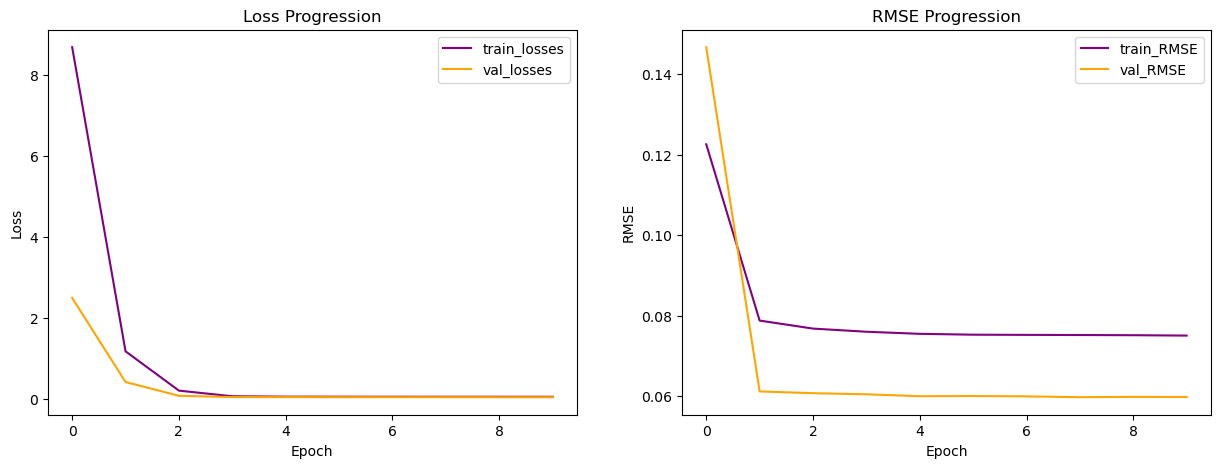

In [67]:
model = build_model(training_features,
                    training_permno,
                    initial_learning_rate=0.00002,
                    decay_steps=1000,
                    decay_rate=0.96,
                    attn_hidden=[256,128,64],
                    embed_hidden=[128,64],
                    hidden=[1024],
                    dropout=0.3)

# get original embeddings
embeddings_untrained = model.get_layer('embeddings').get_weights()[0]

history = model.fit(
   x=[training_permno, training_features],
   y=training_y,
   epochs=10,
   validation_data=(
      [validation_permno, validation_features],
      validation_y
   ),
   batch_size=64,
   callbacks=[callback],
   verbose=1)

# get trained embeddings
embeddings_trained = model.get_layer('embeddings').get_weights()[0]

visualize(history)

# Generate overall predictions & visualize the results

In [ ]:
training_prediction = model.predict([training_permno, training_features])
validation_prediction = model.predict([validation_permno, validation_features])

2789/6854 [===========>..................] - ETA: 21s

In [ ]:
def visualize_results(y_true, y_pred):
  plt.figure(figsize=(10, 4))

  # Plot the true values
  plt.plot(y_true, label='True Value')
  plt.plot(y_pred, label='Predicted Value')

  # Labels and title
  plt.xlabel('Horizon')
  plt.ylabel('Scaled_Return')
  plt.title('Predictions vs. True Values')
  plt.legend()
  plt.show()

In [ ]:
visualize_results(training_y, training_prediction)

In [ ]:
visualize_results(validation_y, validation_prediction)

# Look at the embeddings

In [ ]:
embeddings_untrained.shape

In [ ]:
embeddings_untrained[1:][:2]

In [ ]:
embeddings_trained[1:][:2]

Ignore the 1st embedding element, we have the embeddings corresponding to each permno starting from the 2nd embedding element

# Run cosine similarity on the embeddings

In [ ]:
num_permnos = len(np.unique(training_permno))

# Calculate pairwise cosine similarity
cosine_distances = pdist(embeddings_untrained[1:], metric='cosine')
cosine_similarities = 1 - squareform(cosine_distances)

subset_distances = pdist(embeddings_untrained[1:21], metric='cosine')
subset = 1 - squareform(subset_distances)
# Plot the cosine similarity matrix
plt.figure(figsize=(8, 8))
plt.imshow(subset, cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title('Pairwise Cosine Similarity Between Untrained Embeddings')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.xticks(ticks=np.arange(20), labels=np.arange(20))
plt.yticks(ticks=np.arange(20), labels=np.arange(20))
plt.show()

In [ ]:
num_permnos = len(np.unique(training_permno))

# Calculate pairwise cosine similarity
cosine_distances = pdist(embeddings_trained[1:], metric='cosine')
cosine_similarities = 1 - squareform(cosine_distances)

subset_distances = pdist(embeddings_trained[1:21], metric='cosine')
subset = 1 - squareform(subset_distances)
# Plot the cosine similarity matrix
plt.figure(figsize=(8, 8))
plt.imshow(subset, cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title('Pairwise Cosine Similarity Between Trained Embeddings')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.xticks(ticks=np.arange(20), labels=np.arange(20))
plt.yticks(ticks=np.arange(20), labels=np.arange(20))
plt.show()

# Sample 5 permnos to visualize the true values vs predictions

In [ ]:
visualize_df = pd.DataFrame({'permno_id': training_permno.flatten(),
                             'true_y': training_y.flatten(),
                             'pred_y': training_prediction.flatten()})
visualize_df.head()

In [ ]:
for permno in visualize_df['permno_id'].unique()[:5]:
  print("-"*50, permno, "-"*50)
  visualize_permno = visualize_df[visualize_df['permno_id'] == permno]
  visualize_results(visualize_permno['true_y'], visualize_permno['pred_y'])
  print()

# Put the permnos, embeddings, and, cosine similarities into a dict

In [ ]:
results = {}

results["permno_id"] = np.unique(training_permno)
results["embeddings"] = embeddings_trained[1:]
results["cosine"] = cosine_similarities

In [ ]:
display(results["permno_id"].shape)
display(results["embeddings"].shape)
display(results["cosine"].shape)

In [ ]:
results

# Save the trained embeddings & calculated cosine similarities to a pkl file

In [ ]:
with open('/home/sagemaker-user/capstone-2024-summer/data/crsp_rachel_results_200.pkl', 'wb') as file:
  pickle.dump(results, file)

In [ ]:
s3.upload_file(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_rachel_results_200.pkl",
    bucket,
    "CRSP/crsp_rachel_results_200.pkl",
)